# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [ ]:
!pip install ipywidgets

In [177]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import IntProgress
from torch.utils.data import DataLoader

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [178]:
# Define transforms
transform = transforms.Compose([transforms.ToTensor()])

# Create training set and define training dataloader
training_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)
train_loader = DataLoader(training_data, batch_size=100, shuffle=True)

# Create test set and define test dataloader
test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)

test_set, val_set = torch.utils.data.random_split(test_data, [5000, 5000])

val_loader = DataLoader(val_set, batch_size=100)
test_loader = DataLoader(test_set, batch_size=100)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

In [179]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
torch.device(device)

Using cuda device


device(type='cuda')

In [180]:
print(list(training_data.data.size()))
print(list(test_data.data.size()))
print(len(test_set))
print(len(val_set))

[60000, 28, 28]
[10000, 28, 28]
5000
5000


1. transform image to tensor by calling trsnsform.totensor()

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [181]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

2


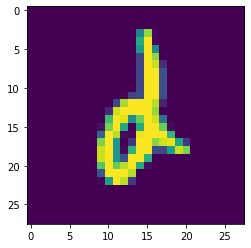

4


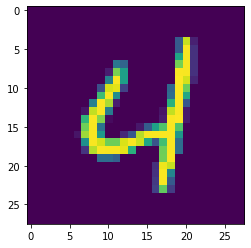

3


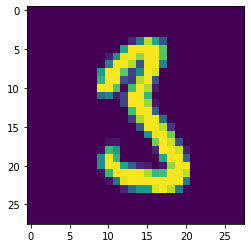

7


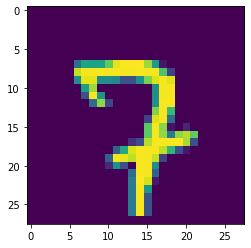

8


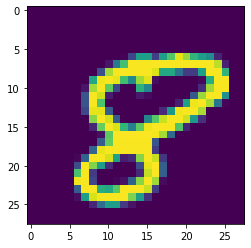

In [182]:
# Explore data
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [183]:
## YOUR CODE HERE ##
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.fc1 = nn.Linear(28 * 28, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Instantiate the model
net = Net().to(device)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [184]:
# Choose an optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001,  momentum=0.9)
# Choose a loss function
criterion = nn.CrossEntropyLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [186]:
num_epochs = 10
# code snippets taken & modifed from udacity current deep learning course
# Establish a list for our history
train_loss_history = list()
val_loss_history = list()



for epoch in range(num_epochs):
    
    net.train()
    train_loss = 0.0
    train_correct = 0
    for i, data in enumerate(train_loader):
        # data is a list of [inputs, labels]
        inputs, labels = data

        # Pass to GPU if available.
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
    print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader):.2f}% training loss: {train_loss/len(train_loader):.5f}')
    train_loss_history.append(train_loss/len(train_loader))


    val_loss = 0.0
    val_correct = 0
    net.eval()
    for inputs, labels in val_loader:
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
    print(f'Epoch {epoch + 1} validation accuracy: {val_correct/len(val_loader):.2f}% validation loss: {val_loss/len(val_loader):.5f}')
    val_loss_history.append(val_loss/len(val_loader))

Epoch 1 training accuracy: 92.16% training loss: 0.26846
Epoch 1 validation accuracy: 93.68% validation loss: 0.23274
Epoch 2 training accuracy: 92.54% training loss: 0.25609
Epoch 2 validation accuracy: 93.88% validation loss: 0.22266
Epoch 3 training accuracy: 92.95% training loss: 0.24509
Epoch 3 validation accuracy: 94.00% validation loss: 0.21279
Epoch 4 training accuracy: 93.11% training loss: 0.23480
Epoch 4 validation accuracy: 94.16% validation loss: 0.20451
Epoch 5 training accuracy: 93.59% training loss: 0.22353
Epoch 5 validation accuracy: 94.40% validation loss: 0.19653
Epoch 6 training accuracy: 93.76% training loss: 0.21559
Epoch 6 validation accuracy: 94.54% validation loss: 0.18813
Epoch 7 training accuracy: 93.98% training loss: 0.20667
Epoch 7 validation accuracy: 94.72% validation loss: 0.18253
Epoch 8 training accuracy: 94.28% training loss: 0.19955
Epoch 8 validation accuracy: 94.92% validation loss: 0.17471
Epoch 9 training accuracy: 94.51% training loss: 0.19071

Plot the training loss (and validation loss/accuracy, if recorded).

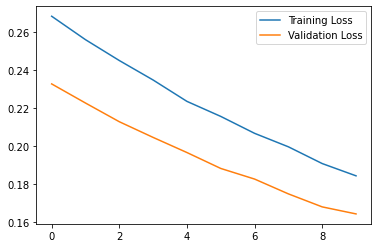

In [187]:
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [191]:
num_epochs = 10
# code snippets taken & modifed from udacity current deep learning course
# Establish a list for our history
train_loss_history = list()
test_loss_history = list()

for epoch in range(num_epochs):
    net.train()
    train_loss = 0.0
    train_correct = 0
    for i, data in enumerate(train_loader):
        # data is a list of [inputs, labels]
        inputs, labels = data

        # Pass to GPU if available.
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
    print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader):.2f}% training loss: {train_loss/len(train_loader):.5f}')
    train_loss_history.append(train_loss/len(train_loader))


    test_loss = 0.0
    test_correct = 0
    net.eval()
    for inputs, labels in test_loader:
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        test_correct += (preds == labels).sum().item()
        test_loss += loss.item()
    print(f'Epoch {epoch + 1} test accuracy: {test_correct/len(test_loader):.2f}% test loss: {test_loss/len(test_loader):.5f}')
    test_loss_history.append(test_loss/len(test_loader))

Epoch 1 training accuracy: 94.89% training loss: 0.17780
Epoch 1 test accuracy: 95.50% test loss: 0.15300
Epoch 2 training accuracy: 95.00% training loss: 0.17169
Epoch 2 test accuracy: 95.56% test loss: 0.14784
Epoch 3 training accuracy: 95.23% training loss: 0.16617
Epoch 3 test accuracy: 95.70% test loss: 0.14380
Epoch 4 training accuracy: 95.34% training loss: 0.16232
Epoch 4 test accuracy: 95.72% test loss: 0.13963
Epoch 5 training accuracy: 95.48% training loss: 0.15535
Epoch 5 test accuracy: 95.84% test loss: 0.13517
Epoch 6 training accuracy: 95.67% training loss: 0.15174
Epoch 6 test accuracy: 95.88% test loss: 0.13321
Epoch 7 training accuracy: 95.78% training loss: 0.14813
Epoch 7 test accuracy: 95.86% test loss: 0.12912
Epoch 8 training accuracy: 95.86% training loss: 0.14327
Epoch 8 test accuracy: 96.04% test loss: 0.12559
Epoch 9 training accuracy: 95.96% training loss: 0.13868
Epoch 9 test accuracy: 96.20% test loss: 0.12297
Epoch 10 training accuracy: 96.13% training lo

## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

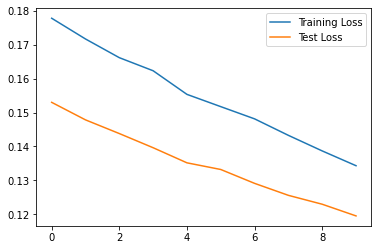

In [192]:
plt.plot(train_loss_history, label="Training Loss")
plt.plot(test_loss_history, label="Test Loss")
plt.legend()
plt.show()

## Saving your model
Using `torch.save`, save your model for future loading.

In [193]:
torch.save({'epoch': num_epochs,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()},'mnist.pt')